In [1]:
%matplotlib inline
import re
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
from spiker import *
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "12"
plt.rcParams['legend.fontsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['axes.labelsize']  = '12'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.autolayout"] = True
plt.rcParams['lines.linewidth'] = 1
orange = '#FFA500'

#from IPython.display import clear_output, Image, display, HTML

In [2]:
# Generate simulation data
def gen_data(nblocks,f1,f2,tseries,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    time = tseries.time
    Ts = tseries.Ts
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op

In [3]:
# Simulation parameters

# Transient simulation parameters for the spiking simulation
Ts = 0.5e-6 # step time
tstart = 0 # Simulation start time in seconds
tstop = 1 # Simulation stop time in seconds
tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
time = tseries.time # the series of time samples


# Neuron constants to setup the neuron model and reserovoir decay
Cmem  = 2e-12 # Membrane cap
Kappa = 0.7
Temp  = 300 # temperature in kelvin
Ut    = 1.38064852e-23 * Temp/1.60217662e-19 # kt/q
Itau  = 50e-12 #50e-12
Ith   = 50e-12 #5e-9
Iin   = 50e-9
gain  = Ith/Itau # DPI gain
tau   = Cmem*Ut/(Kappa * Itau)
print(f'Time constant is {tau} seconds')

# Test data generation
nblocks = 10
f1 = 15
f2 = 4
amp = 10e-9
test_ip, test_op = gen_data(nblocks,f1,f2,tseries,amp)

ip = Tseries(test_ip,time,Ts)
op = Tseries(test_op,time,Ts)

test_ip = np.vstack((amp*np.ones_like(tseries.time),test_ip)) # adding bias
# test_ip = np.vstack((amp*np.zeros_like(tseries.time),test_ip)) # adding bias

Time constant is 0.001477256629974861 seconds


In [121]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 1/Ts      # sample rate, Hz
cutoff = 50  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
# # Plot the frequency response.
# w, h = freqz(b, a, worN=8000)
# plt.subplot(2, 1, 1)
# plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
# plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
# plt.axvline(cutoff, color='k')
# plt.xlim(0, 0.5*fs)
# plt.title("Lowpass Filter Frequency Response")
# plt.xlabel('Frequency [Hz]')
# plt.grid()

C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


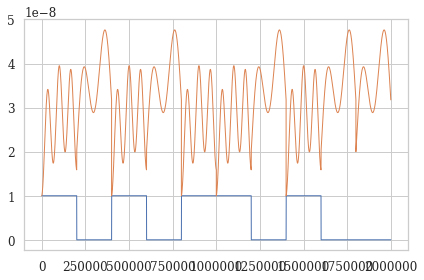

In [5]:
plt.plot(test_op, label='Expected output')
plt.plot(test_ip[1,:], label='Input to be classified')

In [6]:
# --------------------------------
# Standard ESN using real elements
# --------------------------------
def realesn(inSize=1, 
            outSize=1, 
            resSize=20):
    """
    inSize = input dimension
    outSize = output dimension
    resSize = size of the reservoir
    """
    
    # Generate input connectivity weights
    Win = (np.random.rand(resSize,1+inSize)-0.5) * 1

    # Recurrent connecivity weights
    W = np.random.rand(resSize,resSize)-0.5
    # compute the spectral radius
    radius = np.max(np.abs(np.linalg.eigvals(W)))
    # rescale to desired spectral radius
    W = W * (1.0 / radius)

    # Output weights
    Wout = np.random.rand(outSize,1+inSize+resSize)-0.5

    # Generate graph for visualization
    G,W_full = create_graph(W,Win,Wout)
    plt.tight_layout()
    # plt.savefig('ESNgraph.pdf')
    
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)    
    op = np.zeros((outSize,len(tseries.time)))
    x = np.zeros((resSize,1))
    u = np.zeros((inSize+1,))
    states = np.zeros((resSize,len(tseries.time)))
    res = np.zeros((outSize,1))

    t_ip  = np.zeros((inSize+1,len(tseries.time)))
    t_res = np.zeros((resSize,len(tseries.time)))
    
    # the retention factor inside reservoir = exp(-nsamples_in_tau/a)
    # chosen so that in time 10*tau, the value of exponent is almost 0
    a = (1 - np.exp(-Ts/tau))#*0.6
    
    for t in range(len(test_ip[0,:])):
        u.shape = (inSize+1,)
        u = (1-a)*u + a*test_ip[:,t] # filtering input
        #u = test_ip[:,t] # filtering input
        t_ip[:,t] = u + 0
        u.shape = (len(u),1)
        
        data_in = np.dot( Win, u) # First scale data input
        data_in.shape = (resSize,1) # Reshape for dop product
        
        n_ip = np.dot(W, x) + data_in # Input to neuron
        n_ip = np.maximum(n_ip,0) # Apply relu
        x = (1-a)*x + a*n_ip # filtering inside the neuron
        
        res_ip = np.dot(Wout, np.vstack((u,x))) # Input to readouts
        res_ip = np.maximum(res_ip,0) # Apply relu
        res = (1-a)*res + a*res_ip # Filtering in the readout neurons
       
        # Save state transient output
        x.shape = (resSize,)
        states[:,t] = x + 0
        op[:,t] = res[:,0]
        x.shape = (resSize,1)
    return op, states, Win, W, Wout, t_ip

Total nodes # =  55
Input nodes # =  2
Input neuron # =  2
Reservoir neuron # =  50
Output neuron # =  1


C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


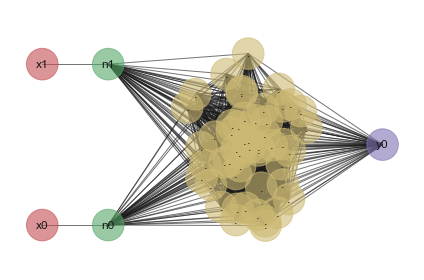

In [7]:
# define reservoir properties
inSize, outSize, resSize = 1, 1, 50

# Let reservoir run
op, ann_res_states, Win, W, Wout, t_ip = realesn(inSize, outSize, resSize)
plt.tight_layout()

plt.savefig('ESNgraph.pdf', dpi=300)

In [8]:
# we'll disregard the first few states and solve for Wout
transient = 0
print(test_ip.shape, ann_res_states.shape)
extended_states = np.concatenate((test_ip, ann_res_states),axis=0)
Wout = np.dot(test_op[transient:], 
               np.linalg.pinv(extended_states[:, transient:]))

(2, 2000000) (50, 2000000)


C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


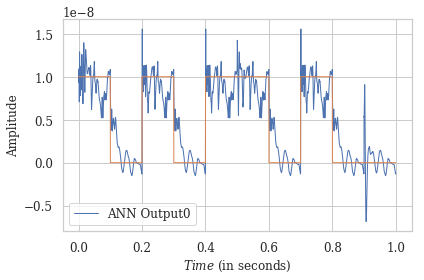

In [9]:
# Compute the output after training
resop = np.dot(Wout, extended_states)
if resop.ndim == 1:
    resop.shape = (1,len(resop))
for index in range(outSize):
    result = Tseries(resop[index,:],tseries.time)
    result.plot(label = "ANN Output"+str(index))
plt.plot(tseries.time, test_op, label = 'Expected output')
#plt.savefig("ANN-ESN.pdf")

In [67]:
# Sigma Delta ESN - numpy
# ---------------------------------
def sdesn(Win, Wout, W,
          nItau=50e-12, 
          nIth=50e-12,
          nfbItau=50e-12,
          nfbIth=50e-12,
          nfbIin_ip=4e-8,
          nfbIin_res=4e-8,
          nfbIin_op=4e-8,
          neItau=10e-12,
          neIth=50e-9,
          nthresh = 0.1e-9
         ):
    """
    Runs transient spiking simulation of an Echo-state 
    network given a set of Win, Wout, and W
    Win = Input connectivity matrix
    Wout = Readout connectivity matrix
    W = Recurrent connectivity matrix
    
    # Variables used in this function:
    # X = input: dim = (nip + 1) x 1
    # N = input neurons to convert X to spikes: dim = nip x 1
    # R = reservoir neurons: dim = nres x nres
    # Y = output neurons: dim = nop x 1
    # Wab = weight matrix such that B = W.A
    # Xip = input to the layer X
    # Xop = output from layer X
    """
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)
    X = test_ip   
    N = Neuron(nnip,
             ipItau  = nItau,
             ipIth   = nIth,
             fbItau  = nfbItau,
             fbIth   = nfbIth,
             fbIin   = nfbIin_ip,
             eItau   = neItau,
             eIth    = neIth,
             thresh  = nthresh,
             Ts=Ts)
    R = Neuron(nnres,
             ipItau  = nItau,
             ipIth   = nIth,
             fbItau  = nfbItau,
             fbIth   = nfbIth,
             fbIin   = nfbIin_res,
             eItau   = neItau,
             eIth    = neIth,
             thresh = nthresh,
             Ts=Ts)

    Wxn = np.eye(nip)
    Wnr = Win
    Wrr = W
    Wry = Wout
        
    Rop = np.zeros(nnres)
    
    esn = np.zeros((nop,len(tseries.time)))
    N_st  = np.zeros((nip,len(tseries.time)))
    R_st  = np.zeros((nnres,len(tseries.time)))
    
    for index in range(len(tseries.time)):
        ip = X[:,index]
    
        Nip = np.dot(Wxn,ip)
        Nop = N.compute(Nip)
        
        Rip = np.dot(Wnr,Nop) + np.dot(Wrr,Rop)
        Rop = R.compute(Rip)
        
        Yip = np.dot(Wry,np.hstack((ip,Rop)))

        esn[:,index] = Yip + 0
        N_st[:,index] = Nop
        R_st[:,index] = Rop

    spike_counts = [N.spike_count, R.spike_count]
    return esn, N_st, R_st, spike_counts

In [95]:
nfbIin_ip  = np.max(t_ip)
nfbIin_res = np.max(ann_res_states)
print('Values of fnIin_ip and fbIin_res = {} and {}'.format(nfbIin_ip, nfbIin_res))

Values of fnIin_ip and fbIin_res = 4.7534806292685015e-08 and 6.982396827353688e-08


In [96]:
# Refined simulation
esn, nN, nR, spike_counts = sdesn(Win, Wout, W
                                , nfbIin_ip=nfbIin_ip
                                , nfbIin_res=nfbIin_res
                                , nthresh=0.1e-9
                               ) # high power, precise

# # Refined simulation
# nfbIin_ip  = np.max(t_ip)
# nfbIin_res = np.max(ann_res_states)
# esn, N, R, spike_counts = sdesn(Win, Wout, W,
#                                      nfbIin_ip=nfbIin_ip, 
#                                      nfbIin_res=nfbIin_ip,
#                                      nthresh = 1e-9) # high power, precise

C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


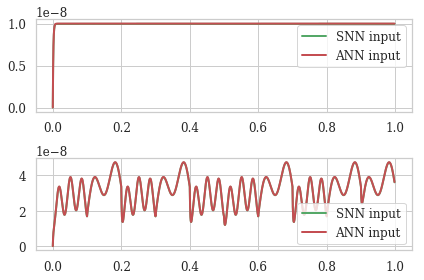

In [97]:
%matplotlib inline
# Plotting input dynamics
N = 2
transient = 0
ds_factor = 2000 # downsample to make plots less dense
fig, axs = plt.subplots(N)
for n in range(N):
    signal = Tseries(nN[n, transient::ds_factor],tseries.time[transient::ds_factor])
    plt.sca(axs[n])
    signal.plot(0.0, color='g', label='SNN input', xlabel=False, ylabel=False, linestyle='-', legend=True)

    signal = Tseries(t_ip[n, transient::ds_factor],tseries.time[transient::ds_factor])
    plt.sca(axs[n])
    signal.plot(0.0, color='r', label='ANN input', xlabel=False, ylabel=False, linestyle='-', legend=True)
    
plt.show()

In [102]:
%matplotlib
plt.rcParams['lines.linewidth'] = 2

# Plotting reservoir dynamics
M = 5
N = 10
transient = 1000000
ds_factor = 2000 # downsample to make plots less dense
fig, axs = plt.subplots(M, N)
for m in range(M):
    for n in range(N):
        signal = Tseries(nR[m*M+n, transient::ds_factor],tseries.time[transient::ds_factor])
        plt.sca(axs[m,n])
        signal.plot(0.0, color='g', xlabel=False, ylabel=False, linestyle='-', legend=False)

        signal2 = Tseries(ann_res_states[m*M+n, transient::ds_factor],tseries.time[transient::ds_factor])
        plt.sca(axs[m,n])
        signal2.plot(0.0, color='k', xlabel=False, ylabel=False, legend=False, linestyle=':')

red_patch = mpatches.Patch(color='k', label='ANN output')
blue_patch = mpatches.Patch(color='g', label='SNN output filtered')

fig.legend(handles=[red_patch, blue_patch], loc='lower center', fancybox=True, shadow=True, fontsize=30)

# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
#plt.show()
# plt.savefig("res_dynamics.pdf", dpi=300)

Using matplotlib backend: Qt5Agg


C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


In [99]:
%matplotlib inline
_,_,nnip,nnres,nop = compute_nodes(Win,Wout,W)
energy_per_spike = 5 # pJ from cadence simulation

nip_spikes = np.sum(spike_counts[0])#np.sum(N)
nR_spikes  = np.sum(spike_counts[1])#np.sum(R)

total_spikes = nip_spikes + nR_spikes

avg_spikes_per_neuron = total_spikes/(nnip + nnres)
avg_spikes_per_ipneuron = nip_spikes/(nnip)
avg_spikes_per_resneuron = nR_spikes/nnres
energy = total_spikes * energy_per_spike
power = energy/tstop # in W

# Mean squre error in normalized raw signal
esn_norm = esn[0,:]/max(esn[0,:])
res_norm = resop[0,:]/max(resop[0,:])
x = np.sum((esn_norm-res_norm)**2)
x = x/len(esn[0,:])

print('All neuron avg = {0:.2f} KHz'.format(1e-3*avg_spikes_per_neuron/tstop))
print('Input neuron rate = {0:.2f} KHz'.format(1e-3*avg_spikes_per_ipneuron/tstop))
print('Reservoir neuron rate = {0:.2f} KHz'.format(1e-3*avg_spikes_per_resneuron/tstop))
print('Expected energy consumption = {0:.2f} uJ'.format(1e-6*energy))
print('Power for this simulation = {0:.3f} mW'.format(1e-9*power))
print(f'MSE in the normalized signal is {x}')

All neuron avg = 127.62 KHz
Input neuron rate = 438.67 KHz
Reservoir neuron rate = 115.18 KHz
Expected energy consumption = 33.18 uJ
Power for this simulation = 0.033 mW
MSE in the normalized signal is 0.0821950678447882


MSE in the normalized filtered signal is 1.2625518993648993e-17


C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


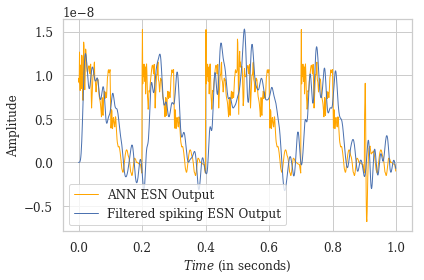

In [142]:
# Downsample spiking esn
ds_factor=2000
esn_norm = esn[0,:]#/max(esn[0,:])
esn_norm_ds = esn_norm[::ds_factor]

# Downsample ANN
res_norm = resop[0,0:]#/max(resop[0,transient:])
res_norm_ds = res_norm[::ds_factor]

# computing the normalized mean squre error - filtered signal
fs = 1/(Ts*ds_factor)
esn_filt = butter_lowpass_filter(esn_norm_ds, cutoff, fs, order)
esn_norm_ds_norm = esn_filt#/max(esn_filt)
res_norm_ds_norm = res_norm_ds#/max(res_norm_ds)
x = np.sum((esn_norm_ds_norm-res_norm_ds_norm)**2)
x = x/len(esn_norm_ds_norm)
# plt.plot(res_norm_ds_norm, orange, label='ANN output',alpha=1,linestyle='-')
# plt.plot(esn_norm_ds_norm, label='Spiking ESN output')

signal = Tseries(res_norm_ds_norm,tseries.time[::ds_factor])
signal.plot(0.0, label = "ANN reservoir Output", color=orange, linestyle='-')

signal = Tseries(esn_norm_ds_norm,tseries.time[::ds_factor])
signal.plot(0.0, label = "Filtered spiking rservoir Output", color='b', linestyle='-')

print(f'MSE in the normalized filtered signal is {x}')
plt.legend(fancybox = True, frameon = True)#, loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig("ANN-SDNN-norm.pdf", dpi=300)

No handles with labels found to put in legend.
C:\Users\Manu\AppData\Local\conda\conda\envs\speech\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


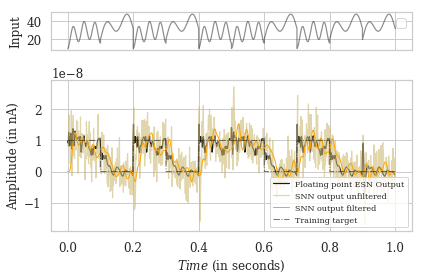

In [130]:
%matplotlib inline
# Generating plots for visualization
plt.rcParams['lines.linewidth'] = 1.2
f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[1, 4]})
plt.sca(axarr[0])
input_signal = Tseries(test_ip[1,:]*1e9, tseries.time[:])
input_signal.plot(ylabeltxt='Input', color='k', xlabel=False,alpha=0.5,linestyle='-')
ds_factor = 2000 # downsample to make plots less dense
#plt.legend(fancybox = True, frameon = True)
transient = 0
plt.sca(axarr[1])
for index in range(nop):
    plt.rcParams['lines.linewidth'] = 1.2
    esnres = Tseries(res_norm_ds_norm,tseries.time[::ds_factor])
    esnres.plot(0.0, label = "Floating point ESN Output", color='k', alpha=1, linestyle='-')

    plt.rcParams['lines.linewidth'] = 1.2
    esnres = Tseries(esn_norm[transient::ds_factor],tseries.time[transient::ds_factor])
    esnres.plot(0.0, label = "SNN output unfiltered", color='y',alpha=0.6, linestyle='-')

    plt.rcParams['lines.linewidth'] = 1
    esnres = Tseries(esn_norm_ds_norm,tseries.time[::ds_factor])
    esnres.plot(0.0, label = "SNN output filtered", color=orange, alpha=1, linestyle='-')

    
    
ideal_op = Tseries(test_op, tseries.time[:])
ideal_op.plot(label = 'Training target', xlabel=False, color='k', ylabeltxt='Amplitude (in nA)',linestyle='-.',alpha=0.6)

f.subplots_adjust(hspace=0.01)
plt.legend(fancybox = True, frameon = True, loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig("ANN-SDNN.pdf", dpi=300)